<a href="https://colab.research.google.com/github/Nik8x/Hospital_Doctor_Referral/blob/master/Hospital_Doctor_Referral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import time
import os
import re

from tqdm import  tqdm_notebook as tqdm

# General Mathematics package
import math as math

# Graphing Packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use("ggplot")

# Statistics Packages
from scipy.stats import randint, skew

# Machine Learning Packages
# !pip install xgboost # if xgboost is not installed
import xgboost
# !pip install sklearn # if sklearn is not installed
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

In [0]:
df_original = pd.read_csv("Test_Data_Set_For_Data_Science_0319.csv")
df = df_original.copy() #make copy of the dataframe so we can mess around with one without affecting the other
df.head()

,DATE_SEQ,id,tier,claim_type,npi_temp
0,1,219286890,Preferred,Facility,Y3260K6K67
1,2,219286890,Preferred,Professional,Y336Y6YY32
2,3,219461214,Preferred,Facility,Y578526695
3,4,219461214,Preferred,Professional,YK57369753
4,5,220660239,Preferred,Professional,Y235Y39585


In [0]:
print('There are', df.shape[0], 'and', df.shape[1], 'columns')

There are 975133 and 5 columns


In [0]:
print(df.tier.value_counts())
print('\n% of Non-Preferred rows in our dataframe is:', df.tier.value_counts()[1]/df.shape[0]*100, '%.')

Preferred        941419
Non-Preferred     33714
Name: tier, dtype: int64

% of Non-Preferred rows in our dataframe is: 3.4573745324996694 %.


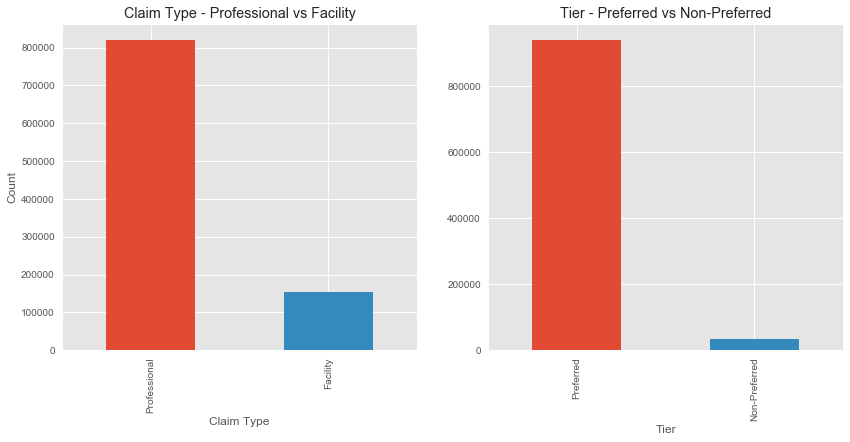

In [0]:
plt.figure(figsize = (14, 6))

plt.subplot(121)
df.claim_type.value_counts().plot(kind = 'bar')
plt.ylabel('Count')
plt.xlabel('Claim Type')
plt.title('Claim Type - Professional vs Facility')

plt.subplot(122)
df.tier.value_counts().plot(kind = 'bar')
plt.xlabel('Tier')
plt.title('Tier - Preferred vs Non-Preferred')
plt.show()

In [0]:
print('Number of unique values in npi_temp is', df.npi_temp.nunique())
print('Number of unique values in id is', df.id.nunique())
print('Number of unique values in Date_sequence is', df.DATE_SEQ.nunique())

Number of unique values in npi_temp is 70166
Number of unique values in id is 136592
Number of unique values in Date_sequence is 975133


In [0]:
# We are trying to find out which doctors are likely to send their members to hospitals which are in tier - non-preferred

In [0]:
# the values of npi_id and id are important, however they are not unique
# we can replace the id and date_seq column with a column representing the number of times particular member has visited for that npi_id

# same we will replace npi_id with the number of times particular medical provider is mentioned
# so we will create a loop that will go through the data frame and find out these values
# this will take some time depending on machines

In [0]:
%%time
count = [len(re.findall(str(j), str(df.id[0: i]))) + 1 for i, j in enumerate(tqdm(df.id))] # extracting the number of visits for particular id for paticular date

In [0]:
%%time
count_npi = [len(re.findall(str(j), str(df.npi_temp[0: i]))) + 1 for i, j in enumerate(tqdm(df.npi_temp))] # extracting the number of visits for particular id for paticular date

In [0]:
with open("count.txt", "w") as output:
     output.write(str(count))  # storing the list  as a local copy for future use

In [0]:
with open("count_npi.txt", "w") as output:
     output.write(str(count_npi))  # storing the list  as a local copy for future use

In [0]:
count_npi = open('count_npi.txt').read()[1:-1].split(', ') # loading a local copy
df['count_npi'] = count_npi

In [0]:
count = open('count.txt').read()[1:-1].split(', ') # loading a local copy
df['count'] = count

In [0]:
print('The length of both count:', len(count), 'and count_npi:', len(count_npi), 'are the same as the length of the data frame')

The length of both count: 975133 and count_npi: 975133 are the same as the length of the data frame


In [0]:
pd.crosstab(df.tier, pd.to_numeric(df['count'])).T

tier,Non-Preferred,Preferred
count,,
1,14260,679545
2,11161,162507
3,4714,56925
4,1996,23387
5,840,9479
6,392,4324
7,174,2221
8,79,1222
9,45,674


In [0]:
# From here we can see that how many times a patient visited (count) and was non-preferred and preferred

# for example, there were 840 people that visited a total of 5 times who ended up being non-preferred
# and, there were 9479 people that visited a total of 5 times who ended up being preferred

# More frequent visits leads the member to be Preferred 
# while less vists can be Non-Preferred Tier too

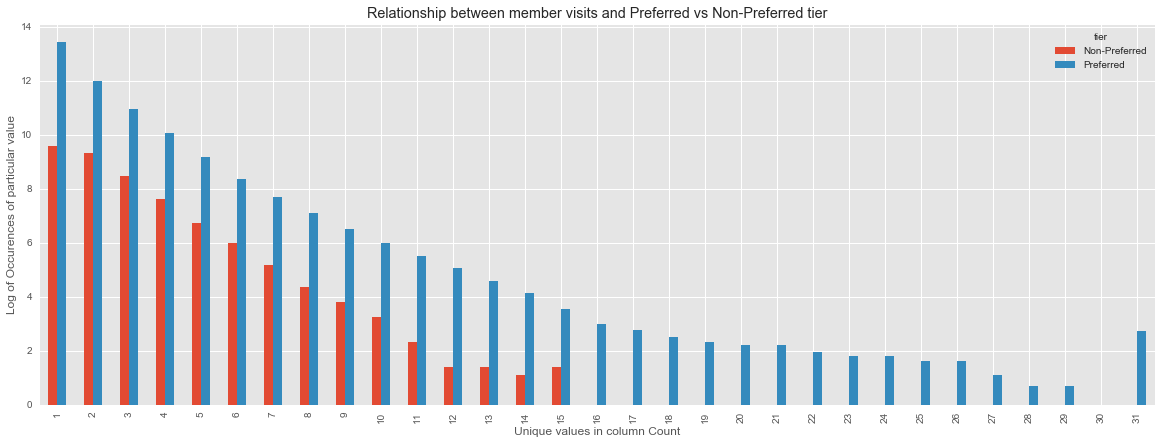

In [0]:
np.log(pd.crosstab(df.tier, pd.to_numeric(df['count']))).T.plot(kind = 'bar', figsize = (20, 7))
plt.ylabel('Log of Occurences of particular value')
plt.xlabel('Unique values in column Count')
plt.title('Relationship between member visits and Preferred vs Non-Preferred tier')
plt.show()

In [0]:
# drop unnecessary column DATE_SEQ
df_1 = df.copy()
df_1.drop(['DATE_SEQ', 'id' , "npi_temp"], axis = 1, inplace = True)

# We retained the properties of the columns "Date_Seq", "id" and "npi_temp", so we can finally drop the columns 
# which can help  creating an exceptional model.

df_1.head()
# count is the number of times the patient was seen
# count_npi is the number of times that particular medical provider saw the patient

,tier,claim_type,count_npi,count
0,Preferred,Facility,1,1
1,Preferred,Professional,1,2
2,Preferred,Facility,1,1
3,Preferred,Professional,1,2
4,Preferred,Professional,1,1


In [0]:
le = preprocessing.LabelEncoder() # to encode our categorical columns into 0 and 1
le_tier = preprocessing.LabelEncoder()

In [0]:
df_1.tier = le_tier.fit_transform(df_1.tier)

df_1.claim_type = le.fit_transform(df_1.claim_type)

# By using preprocessing.labelenconder we can transform a particular column into categorical numbers ex. (0,1) because our  
# machine learning model only accepts numbers

In [0]:
df_1.head()

,tier,claim_type,count_npi,count
0,1,0,1,1
1,1,1,1,2
2,1,0,1,1
3,1,1,1,2
4,1,1,1,1


In [0]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975133 entries, 0 to 975132
Data columns (total 4 columns):
tier          975133 non-null int32
claim_type    975133 non-null int32
count_npi     975133 non-null object
count         975133 non-null object
dtypes: int32(2), object(2)
memory usage: 22.3+ MB


In [0]:
df_1["count"] = pd.to_numeric(df_1["count"])
df_1["count_npi"] = pd.to_numeric(df_1["count"])

# Since our count and count_npi columns have numbers it is best to leave them as intergers instead of categorical

In [0]:
df_1.tier.value_counts()

1    941419
0     33714
Name: tier, dtype: int64

In [0]:
# There is huge class imbalance, but first we can check the AUROC score to see how well the model can distinguish
# classes in the imbalance data set

In [0]:
X_tier = df_1.drop(["tier"] , axis = 1)
y_tier = df_1["tier"]

X_train, X_val, y_train, y_val = train_test_split(X_tier, y_tier, test_size = 0.3, random_state=42)

In [0]:
logreg = LogisticRegression()
logreg.fit(X_train , y_train)
y_pred = logreg.predict(X_val)

print(classification_report(y_val , y_pred))
print("Accuracy of model is", accuracy_score(y_val , y_pred)*100,"%")
print("AUROC score is:", roc_auc_score(y_val, y_pred) )
print("This is the category the model is predicting:",np.unique(y_pred))

# Our model can only distinguish classes 50% of the time which is not ideal, so let's balance the dataset

              precision    recall  f1-score   support

           0       0.11      0.00      0.01     10153
           1       0.97      1.00      0.98    282387

   micro avg       0.96      0.96      0.96    292540
   macro avg       0.54      0.50      0.49    292540
weighted avg       0.94      0.96      0.95    292540

Accuracy of model is 96.46475695631366 %
AUROC score is: 0.5009472023927313
This is the category the model is predicting: [0 1]


In [0]:
# the huge difference mirrors the imbalance in the classes in tier
# we will make the classes more balanced by upsampling class with minority 

In [0]:
# Separate majority and minority classes
df_majority = df_1[df_1.tier==1]
df_minority = df_1[df_1.tier==0]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_1.tier[df_1.tier == 1]),    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.tier.value_counts()

1    941419
0    941419
Name: tier, dtype: int64

In [0]:
# Now that we balanced it we can do our final machine learning to get an ideal model

X_tier = df_upsampled.drop(["tier"] , axis = 1)
y_tier = df_upsampled["tier"]

X_train, X_val, y_train, y_val = train_test_split(X_tier, y_tier, test_size = 0.3, random_state=42)

In [0]:
logreg = LogisticRegression()
logreg.fit(X_train , y_train)
y_pred = logreg.predict(X_val)

print("Accuracy of our model is: ",round(accuracy_score(y_val , y_pred)*100,2),"%")
print("AUROC score is: ", roc_auc_score(y_val, y_pred) )
print("This is the category the model is predicting:", np.unique(y_pred))

Accuracy of our model is:  93.66 %
AUROC score is:  0.9366091164135117
This is the category the model is predicting: [0 1]


In [0]:
# Logistic accuracy and AUCROC score are same. That means our model should not be affected by the imbalance nature of dataset
# let's build xgboost model

In [0]:
xg = xgboost.XGBClassifier(objective = 'reg:logistic', n_estimators = 2, seed=1234)
xg.fit(X_train, y_train)

y_pred_XGB = xg.predict(X_val)

print("XgBoost Accuracy is:", round(accuracy_score(y_val, y_pred_XGB)*100,2) , "%")
print("This is the category the model is predicting:", np.unique(y_pred_XGB))

XgBoost Accuracy is: 93.66 %
This is the category the model is predicting: [0 1]


In [0]:
# We can see we ran two models and got roughly the same accuracy and the AUROC score
# 93% is fairly good when creating machine learning models

In [0]:
# Now we are going to create a function that can shoot a prediction (Preferred or non-preferred)
# When placing the data in the model

In [0]:
def prediction(df_input):
    #df_input = df_original.head(1).copy()

    if len(re.findall(str(df_input.id[0]), str(df.id))) > 0:
        df_input['count'] = (len(re.findall(str(df_input.id[0]), str(df.id)))+ 1)
    else:
        df_input['count'] = 1

    if len(re.findall(str(df_input.npi_temp[0]), str(df.npi_temp))) > 0:
        df_input['count_npi'] = (len(re.findall(str(df_input.npi_temp[0]), str(df.npi_temp)))+ 1) 
    else:
        df_input['count_npi'] = 1

    df_input.drop(['DATE_SEQ', 'id', 'npi_temp'], axis = 1, inplace = True)

    df_input.claim_type = le.transform(df_input.claim_type)

    y_pred = xg.predict(df_input[['claim_type', 'count_npi', 'count']])

    return pd.DataFrame(le_tier.inverse_transform(y_pred))

# This function gives us a prediction on a single row of data.

In [0]:
# creating new row by randomly replacing values in our data 

In [0]:
my_input = df_original.head(1).copy()
my_input.id[0] = 218285130
my_input.npi_temp[0] = 'Z3260K6K67'
my_input

,DATE_SEQ,id,tier,claim_type,npi_temp
0,1,218285130,Preferred,Facility,Z3260K6K67


In [0]:
prediction(my_input)

# I created bogus id and npi numbers to test we can get prediction on some unknown data

,0
0,Non-Preferred


In [0]:
# looking for predictions on the given data
for i in range(5):
    print(prediction(df.iloc[i:i+1].reset_index()))

               0
0  Non-Preferred
           0
0  Preferred
               0
0  Non-Preferred
           0
0  Preferred
           0
0  Preferred
